<div style="width:100%">
    <img src='image.png' style="max-width:100%; height:auto;">
</div>

<div style="background-color: lightblue; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h1><b>Data Import</b></h1>
</div>

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, HTML

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
from datetime import datetime 
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
pd.set_option('display.max_columns',30)
import random 
import warnings
warnings.filterwarnings("ignore")

from scipy import sparse
# !pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

first_run =1

sns.set_style('whitegrid')

In [2]:
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')
tag = pd.read_csv('ml-latest-small/tags.csv')

In [3]:
def basic_info(dfs):
    for df in dfs:
        print(df.shape,"\n"+"*"*100)
        print(df.info(),"\n"+"*"*100)
        print(df.columns,"\n"+"*"*100)
        print(df.sample(10),"\n"+"*"*100)
        print(df.describe(include='all'),"\n"+"*"*100)
        print("\n\n"+"#"*100)
    return

In [4]:
basic_info([tag])

(3683, 4) 
****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None 
****************************************************************************************************
Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object') 
****************************************************************************************************
      userId  movieId                tag   timestamp
1447     474     1423   In Netflix queue  1137202085
2072     474     6104              spoof  1138039279
1266     474     1030             Disney  1137374219
1225     4

<div style="background-color: lightblue; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h1><b>Movies Dataset EDA</b></h1>
</div>

## Cleaning, Visuals and Feature Engineering

In [5]:
def clean_title(title):
    '''A function to clean the all the non-charaters'''
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [6]:
def year_extract(title):
    ''' A function to extract title year from the title column'''
    title = title.split()
    if bool(re.match("[0-9]",title[-1])):
        return title[-1]
    else:
        return None

In [7]:
movies['title'] = movies['title'].apply(clean_title)
movies['release_year'] = movies['title'].apply(year_extract)


In [8]:
movies.isnull().sum()

movieId          0
title            0
genres           0
release_year    10
dtype: int64

In [9]:
movies[movies['release_year'].isnull()]

,movieId,title,genres,release_year
9031,140956,Ready Player One,Action|Sci-Fi|Thriller,None
9091,143410,Hyena Road,(no genres listed),None
9138,147250,The Adventures of Sherlock Holmes and Doctor W...,(no genres listed),None
9179,149334,Nocturnal Animals,Drama|Thriller,None
9259,156605,Paterson,(no genres listed),None
9367,162414,Moonlight,Drama,None
9448,167570,The OA,(no genres listed),None
9514,171495,Cosmos,(no genres listed),None
9515,171631,Maria Bamford Old Baby,(no genres listed),None
9611,176601,Black Mirror,(no genres listed),None


In [10]:
movies.loc[9515,:]

movieId                         171631
title           Maria Bamford Old Baby
genres              (no genres listed)
release_year                      None
Name: 9515, dtype: object

In [11]:
if first_run==1: #For first run only
    first_run+=1
    movies.loc[9031,'release_year']='2018' #Ready Player One
    movies.loc[9091,'release_year']= '2015' # Hyena Road
    movies.loc[9138,'release_year']= '1980' #The Adventures of Sherlock Holmes and Dr. Watson
    movies.loc[9179,'release_year']= '2016' #Nocturnal Animals
    movies.loc[9259,'release_year']= '2016' #Paterson
    movies.loc[9367,'release_year']= '2016' #Moonlight
    movies.loc[9448,'release_year']= '2017' #The OA
    movies.loc[9514,'release_year']= '2014' #Cosmos
    movies.loc[9515,'release_year']= '2017' #Maria Bamford Old Baby
    movies.loc[9518,'release_year']= '2006' #Death Note
    movies.loc[9525,'release_year']= '2017' #Generation Iron 2
    movies.loc[9611,'release_year']= '2011' #Black Mirror

    
    for i in [9031,9091,9138,9179,9259,9031,9448,9514,9515,9518,9525,9611]:
        movies.loc[i,'title'] = str(movies.loc[i,'title'])+ ' ' + str(movies.loc[i,'release_year'])
        
    # movies['release_year'] = pd.to_numeric(movies['release_year'])

In [12]:
# diff. genres present

genres = list(set('|'.join(movies['genres']).split('|')))
print("There are total",len(genres)-1,"present in the data namely:\n\n",genres)

There are total 19 present in the data namely:

 ['Musical', 'Film-Noir', 'Crime', 'Adventure', 'Mystery', 'Children', 'Western', 'Documentary', 'Action', 'Sci-Fi', 'Thriller', 'Fantasy', '(no genres listed)', 'Drama', 'Horror', 'Comedy', 'Animation', 'IMAX', 'Romance', 'War']


In [13]:
print("There are",len(movies[movies['genres']=='(no genres listed)']),"movies where the genre information is absent.")

There are 34 movies where the genre information is absent.


In [14]:
movies.nunique() # Unique Values for each columns

movieId         9742
title           9737
genres           951
release_year     107
dtype: int64

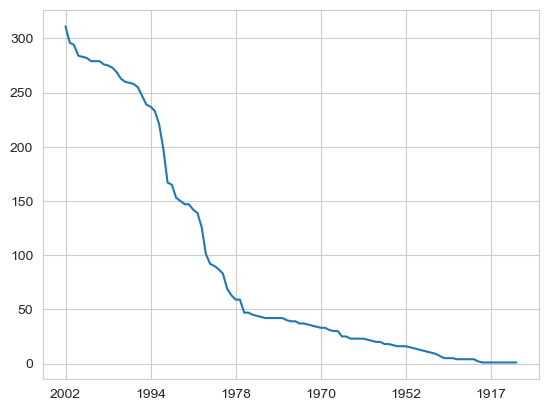

In [15]:
# year wise counts of movies
movies['release_year'].astype('O').value_counts().plot();

In [16]:
# Creating a dictionary using the genres as keys
genre_matrix = dict()
for i in genres:
    genre_matrix[i] = list()

In [17]:
def genre_matrix_func(list_genre):
    ''' A function to create the genre sparse matrix from movies genre column'''
    
    for i in genre_matrix.keys():
        if i in list_genre:
            genre_matrix[i].append(1)
        else:
            genre_matrix[i].append(0)
    return "row done"

In [18]:
movies['genres'].apply(genre_matrix_func) # applying the above function on data

genre_matrix_df = pd.DataFrame(genre_matrix) # Creating the genre matrix dataframe

movies = pd.concat([movies,genre_matrix_df], axis=1) # Concatenating the matrix with original datafrome

movies.drop('genres',axis=1,inplace=True)
movies.rename({'(no genres listed)' : 'NA'},axis=1,inplace=True)
movies.columns = '|'.join(movies.columns).replace(' ','_').replace('-',"_").split('|')
movies.head()

,movieId,title,release_year,Musical,Film_Noir,Crime,Adventure,Mystery,Children,Western,Documentary,Action,Sci_Fi,Thriller,Fantasy,NA,Drama,Horror,Comedy,Animation,IMAX,Romance,War
0,1,Toy Story 1995,1995,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0
1,2,Jumanji 1995,1995,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men 1995,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,4,Waiting to Exhale 1995,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
4,5,Father of the Bride Part II 1995,1995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:
genres_cols = ['NA', 'Comedy', 'Musical', 'Horror',
       'Thriller', 'Western', 'Children', 'Action', 'Fantasy', 'Mystery',
       'Sci_Fi', 'Animation', 'War', 'Adventure', 'Film_Noir', 'Crime',
       'Documentary', 'Romance', 'Drama', 'IMAX']

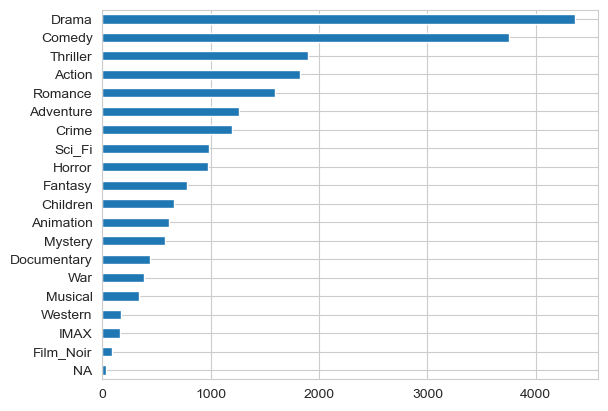

In [20]:
movies[genres_cols].sum().sort_values().plot(kind='barh'); # genrewise movies distribution

## Vectorization and Finding Similar movie titles 

In [21]:
tf_idf_vecs = TfidfVectorizer(ngram_range=(1,4))
tf_idf_result = tf_idf_vecs.fit_transform(movies['title'])

tf_idf_result = sparse.csr_matrix(np.concatenate((tf_idf_result.toarray(),np.array(genre_matrix_df.values)),axis=1))
# tf_idf_result = (np.concatenate((tf_idf_result.toarray(),np.array(genre_matrix_df.values)),axis=1))


In [22]:
def find_matching_names_vec(title):
    
    ''' This functions searches the matching titles in the tfidf result's sparse matrix'''
    
    result_vec = []
    indices = []
    for i,j in enumerate(movies['title']):
        if title.lower() in j.lower():
            indices.append(i)
            result_vec.append(tf_idf_result[i,:].toarray()[0])
    return result_vec,indices

In [23]:
def search_similar_titles(title):
    
    ''' This function will calulate the similarity between the query vector & tfidf result and finds the most similar movies from the data'''
    
    query_vec = np.array(find_matching_names_vec(title)[0])
    indices = np.array(find_matching_names_vec(title)[1])
    if len(query_vec)==1:
        similarity = cosine_similarity(query_vec, tf_idf_result).flatten()
        indices = np.argpartition(similarity, -11)[-11:-1]
        results = movies.loc[indices,'title'].iloc[::-1].values
        return pd.DataFrame(results,columns=['movies'])
    else:
        print("found multiple matches, Enter one of following:")
        return movies.loc[indices,'title'].values



<div style="background-color: orange; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h2><b>Widget for Similar Genre Movies Finding</b></h2>
</div>

In [271]:
# Widget Creation 
movie_input = widgets.Text(
    value='Toy Story 1995',
    description='<h3>Movie Title:</h3>',
    disabled=False,
    style={'description_width': '100px'}
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search_similar_titles(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Toy Story 1995', description='<h3>Movie Title:</h3>', style=DescriptionStyle(description_width='10…

Output()

<div style="background-color: lightblue; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h1><b>Ratings Dataset EDA</b></h1>
</div>

In [25]:
# number of unique users who have given ratings
ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [26]:
ratings.shape

(100836, 4)

In [27]:
ratings['timestamp_cleaned']= ratings['timestamp'].apply(datetime.fromtimestamp)

# Day of Week
ratings['DOW'] = ratings['timestamp_cleaned'].dt.day_name()

In [28]:
ratings.head()

,userId,movieId,rating,timestamp,timestamp_cleaned,DOW
0,1,1,4.0,964982703,2000-07-31 00:15:03,Monday
1,1,3,4.0,964981247,2000-07-30 23:50:47,Sunday
2,1,6,4.0,964982224,2000-07-31 00:07:04,Monday
3,1,47,5.0,964983815,2000-07-31 00:33:35,Monday
4,1,50,5.0,964982931,2000-07-31 00:18:51,Monday


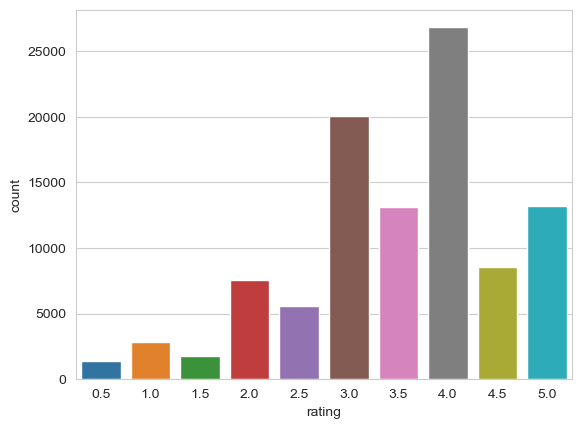

In [29]:
sns.countplot(data=ratings,x='rating');# note that most of the people have rated the movies between 3 to 5

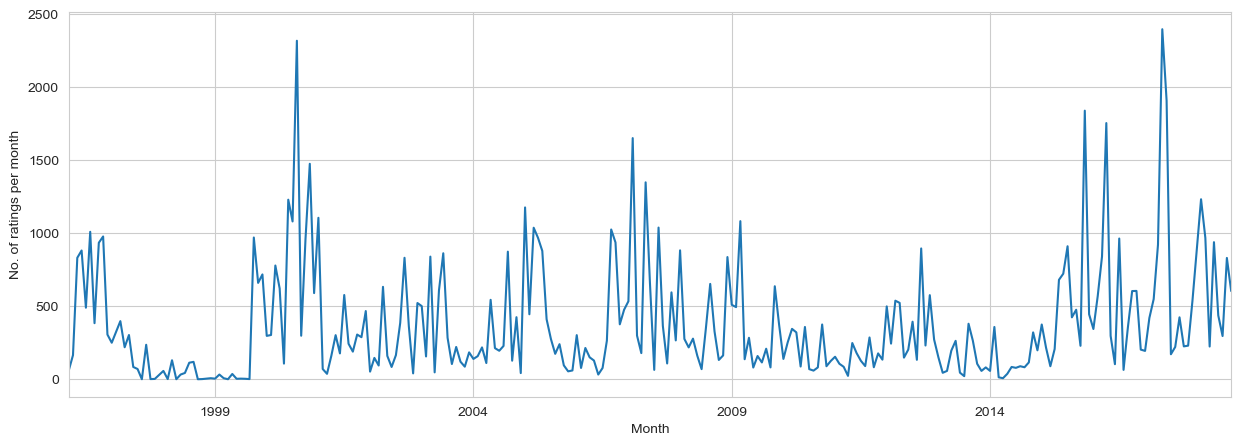

In [30]:
plt.figure(figsize=[15,5])
ratings.resample('m',on='timestamp_cleaned')['rating'].count().plot();

plt.ylabel("No. of ratings per month")
plt.xlabel("Month")
plt.show()

## Users X Ratings

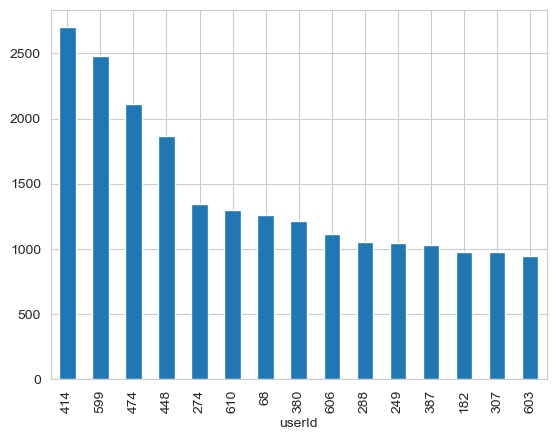

In [31]:
# Top 15 users ordered by number of ratings (who have rated more number of movies)
no_movies_rated_per_user = ratings.groupby(['userId'])['rating'].count()
no_movies_rated_per_user.sort_values(ascending=False)[:15].plot(kind='bar');

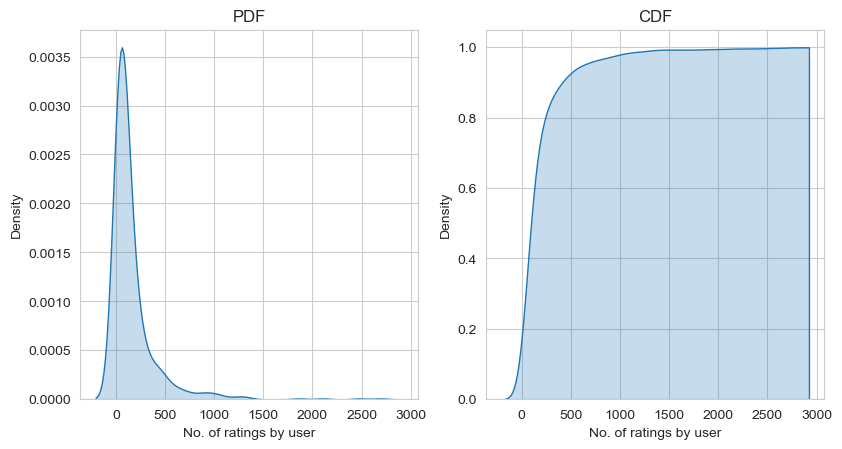

In [32]:
plt.figure(figsize=plt.figaspect(.5))
plt.subplot(121)
sns.kdeplot(no_movies_rated_per_user,fill=True)
plt.xlabel("No. of ratings by user")
plt.title("PDF")

plt.subplot(122)
sns.kdeplot(no_movies_rated_per_user,cumulative=True,fill=True)
plt.xlabel("No. of ratings by user")
plt.title("CDF");

In [33]:
no_movies_rated_per_user.describe(percentiles=[.10,.25,.50,.75,.90,.95]) # Note the 50% percentile is 70 movies which is quite a lot from each user

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
10%        24.000000
25%        35.000000
50%        70.500000
75%       168.000000
90%       400.300000
95%       610.750000
max      2698.000000
Name: rating, dtype: float64

In [34]:
# Total number of users who have rated more that .95 percentile (i.e. 610) movies
no_movies_rated_per_user[no_movies_rated_per_user>np.percentile(no_movies_rated_per_user,95)].count()

31

## Movies X Ratings

In [35]:
no_ratings_per_movie = ratings.groupby(['movieId'])['rating'].count()

In [36]:
# Top 15 movies which have been rated most
movies[movies['movieId'].isin(no_ratings_per_movie.sort_values(ascending=False)[:15].index)]['title']

0                                          Toy Story 1995
46                                Usual Suspects The 1995
97                                        Braveheart 1995
224                 Star Wars Episode IV  A New Hope 1977
257                                     Pulp Fiction 1994
277                         Shawshank Redemption The 1994
314                                     Forrest Gump 1994
418                                    Jurassic Park 1993
461                                  Schindlers List 1993
507                        Terminator 2 Judgment Day 1991
510                         Silence of the Lambs The 1991
898     Star Wars Episode V  The Empire Strikes Back 1980
1939                                      Matrix The 1999
2145                                 American Beauty 1999
2226                                      Fight Club 1999
Name: title, dtype: object

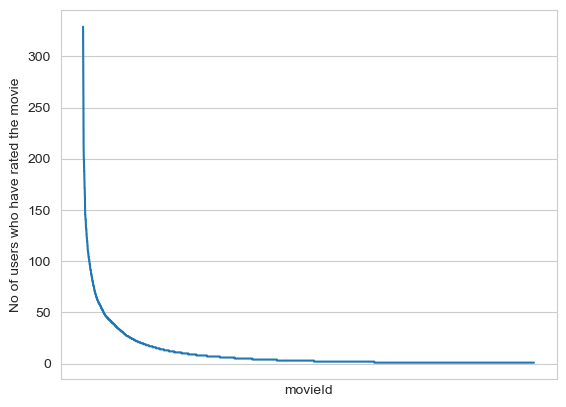

In [37]:
plt.plot(no_ratings_per_movie.sort_values(ascending=False).values)
plt.xlabel('movieId')
plt.xticks([])
plt.ylabel('No of users who have rated the movie');

In [38]:
# Note the 50% percentile is at 3 which means more than 50% of movies have been rated more than 3 times
no_ratings_per_movie.describe(percentiles=[.10,.25,.50,.75,.90,.95]) 

count    9724.000000
mean       10.369807
std        22.401005
min         1.000000
10%         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
90%        27.000000
95%        47.000000
max       329.000000
Name: rating, dtype: float64

In [39]:
# Total number movies who have been rated more that .95 percentile (i.e. 47) times
no_ratings_per_movie[no_ratings_per_movie>np.percentile(no_ratings_per_movie,95)].count()

473

## Ratings X Day of Week Interactions?

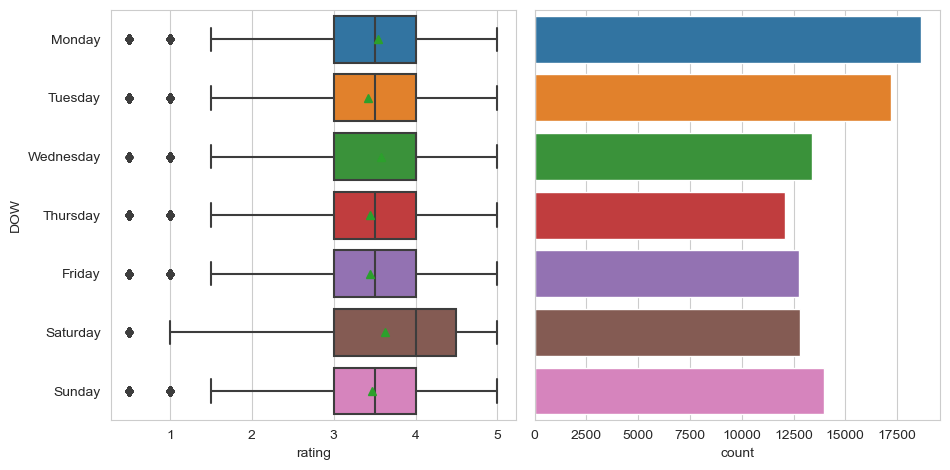

In [40]:
dow_label_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize=plt.figaspect(.5))
plt.subplot(121)
sns.boxplot(data=ratings,x='rating',y='DOW',order=dow_label_order,showmeans=True);

plt.subplot(122)
sns.countplot(data=ratings,y='DOW',order=dow_label_order);
plt.yticks([])
plt.ylabel('')
plt.tight_layout()

Though the number of observations is different for each day, the mean of ratings for each days is the same. Hence, it will most probably not be a good predictor when it comes to predict the rating.

## Ratings vs Time of Day

In [41]:
def get_time_of_day(timestamp):
    hour = timestamp.hour
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'noon'
    elif 17 <= hour < 20:
        return 'evening'
    else:
        return 'night'

In [42]:
ratings['time_of_day'] = ratings['timestamp_cleaned'].apply(get_time_of_day)

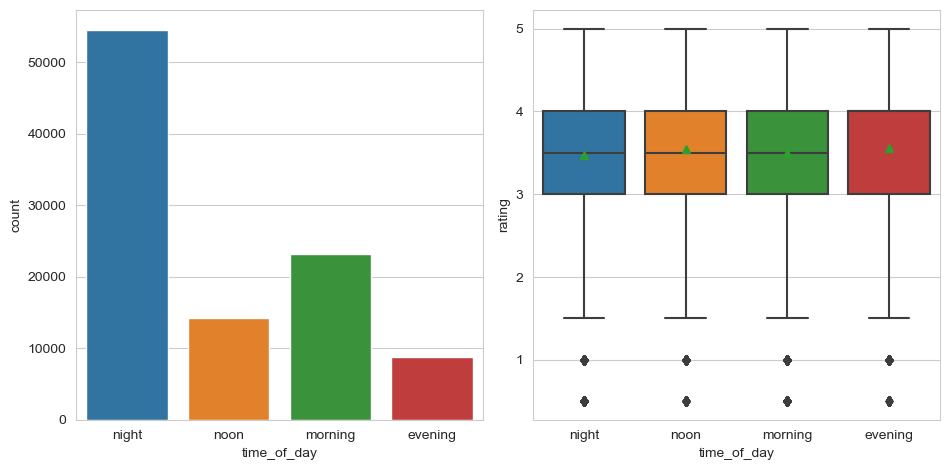

In [43]:
plt.figure(figsize=plt.figaspect(.5))
plt.subplot(121)
sns.countplot(data = ratings, x = 'time_of_day')

plt.subplot(122)
sns.boxplot(data=ratings,y='rating',x='time_of_day',showmeans=True)
plt.tight_layout();

Though the number of observations is different for each time_of_day, the mean of ratings for each time_of_day is the same. Hence, it will most probably not be a good predictor when it comes to predict the rating.

## Creating train and test dataset

In [44]:
ratings_sorted = ratings.sort_values(by='timestamp_cleaned',ascending=True).drop(['DOW','time_of_day','timestamp'],axis=1).reset_index(drop=True)
train_df = ratings_sorted.loc[:int(0.80*ratings_sorted.shape[0]),:]
test_df = ratings_sorted.loc[int(0.80*ratings_sorted.shape[0]):,:]

In [45]:
def sparse_matrix_generation(df,df_name):
    if os.path.isfile(f'{df_name}_sparse_matrix.npz'):
        print("It is present in your pwd, getting it from disk....")
        # just get it from the disk instead of computing it
        gen_sparse_matrix = sparse.load_npz(f'{df_name}_sparse_matrix.npz')
        print("DONE..\n")
    else: 
        print("We are creating sparse_matrix from the dataframe..")
        # creating sparse_matrix and store it for after usage.
        # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
        # It should be in such a way that, MATRIX[row, col] = data
        gen_sparse_matrix = sparse.csr_matrix((df['rating'].values, (df['userId'].values,
                                                   df['movieId'].values)),)

        print('Done. It\'s shape is : (user, movie) : ',gen_sparse_matrix.shape)
        print('Saving it into disk for furthur usage..')
        # save it into disk
        sparse.save_npz(f"{df_name}_sparse_matrix.npz", gen_sparse_matrix)
        print('Done..\n')
    
    return gen_sparse_matrix

In [46]:
# TRAIN Sparse Matrix

train_sparse_matrix = sparse_matrix_generation(train_df,'train')
us,mv = train_sparse_matrix.shape
elements = train_sparse_matrix.count_nonzero()
print("Sparsity of Matrix:",(1-(elements/(us*mv)))*100)

It is present in your pwd, getting it from disk....
DONE..

Sparsity of Matrix: 99.91477404488327


In [47]:
# TEST Sparse Matrix

test_sparse_matrix = sparse_matrix_generation(test_df,'test')
us,mv = test_sparse_matrix.shape
elements = test_sparse_matrix.count_nonzero()
print("Sparsity of Matrix:",(1-(elements/(us*mv)))*100)

It is present in your pwd, getting it from disk....
DONE..

Sparsity of Matrix: 99.98295119916014


## Cold Start Problem

In [48]:
# Users which are present in both train and test datasets
common_users = test_df[test_df['userId'].isin(train_df['userId'].unique())]['userId'].nunique()
common_movies = test_df[test_df['movieId'].isin(train_df['movieId'].unique())]['movieId'].nunique()

In [49]:
# new customers in test set
print("Number of new customers in test set:",test_df['userId'].nunique() - common_users)
print("% of new customers in test set:",np.round((test_df['userId'].nunique() - common_users)*100/ratings['userId'].nunique(),2),'%')

Number of new customers in test set: 88
% of new customers in test set: 14.43 %


In [50]:
# new movies in test set
print("Number of new customers in test set:",test_df['movieId'].nunique() - common_movies)
print("% of new customers in test set:",np.round((test_df['movieId'].nunique() - common_movies)*100/ratings['movieId'].nunique(),2),'%')

Number of new customers in test set: 1857
% of new customers in test set: 19.1 %


## User-User-Similarity-Matrix from User-Movie-Sparse-matrix

In [51]:
if not os.path.isfile('u_u_sim_sparse.npz'):
    print("It seems that the file is not present. Computing movie_movie similarity")
    u_u_sim_sparse = cosine_similarity(X=train_sparse_matrix, dense_output=False)
    # storing this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("u_u_sim_sparse.npz", u_u_sim_sparse)
    print("Done..\n")
else:
    print("It is there, Let's get it.")
    u_u_sim_sparse = sparse.load_npz("u_u_sim_sparse.npz")
    print("Done ..\n")

print("It's a",u_u_sim_sparse.shape,"dimensional matrix")

It is there, Let's get it.
Done ..

It's a (610, 610) dimensional matrix


## Movie-Movie-Similarity-Matrix from User-Movie-Sparse-matrix

In [52]:
if not os.path.isfile('m_m_sim_sparse.npz'):
    print("It seems that the file is not present. Computing movie_movie similarity")
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    # storing this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..\n")
else:
    print("It is there, Let's get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ..\n")

print("It's a",m_m_sim_sparse.shape,"dimensional matrix")

It is there, Let's get it.
Done ..

It's a (155169, 155169) dimensional matrix


In [53]:
train_df['movieId'].max()

155168

In [54]:
def movie_finder(movie_name):
    matches = movies[movies['title'].str.contains(movie_name,flags=re.IGNORECASE)]
    
    if len(matches)>1:
        print("Found following matches:\n")
        print( matches[matches['movieId']<155168][['movieId','title']],'\n') # Since we have used only train sparse matrix to create the m_m_sparse_matrix
        print("Enter selection of the movieId below")
        
        movieID = int(input("MovieID:"))

        if movieID not in matches['movieId'].values:
            return "Try entering a correct ID from selection"
        
        similar_movies_indices = np.argpartition(m_m_sim_sparse[movieID].toarray().ravel(),-10)[-10:]

    else:
        movieID = matches['movieId']
        similar_movies_indices = np.argpartition(m_m_sim_sparse[movieID].toarray().ravel(),-10)[-10:]
        
        
    return movies[movies['movieId'].isin(similar_movies_indices)][['movieId','title']]

In [55]:
movie_finder("Mask The 1994")

,movieId,title
97,110,Braveheart 1995
275,316,Stargate 1994
302,344,Ace Ventura Pet Detective 1994
322,364,Lion King The 1994
325,367,Mask The 1994
337,380,True Lies 1994
418,480,Jurassic Park 1993
436,500,Mrs Doubtfire 1993
506,588,Aladdin 1992
509,592,Batman 1989


<div style="background-color: lightblue; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h1><b>Machine Learning Models</b></h1>
</div>

## Getting the important averages

In [56]:
def get_average_ratings(sparse_matrix, of_users):
    '''get the user averages in dictionary (key: userId/movieId, value: avg rating)'''
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [57]:
# GLOBAL RATING AVG.

train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
print(train_averages)


# AVG. RATING PER USER 

train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


# AVG. RATING PER MOVIE

train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\nAverage rating of movie 15 :',train_averages['movie'][15])



{'global': 3.5084976880834025}

Average rating of user 10 : 3.2785714285714285

Average rating of movie 15 : 3.125


## Featurizing train dataset

In [58]:
train_users,train_movies,train_ratings = train_df[['userId','movieId','rating']].T.values

In [59]:
start = datetime.now()
if os.path.isfile('./reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(train_ratings)))
    with open('./reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(train_users,train_movies,train_ratings):
            st = datetime.now()
        #     print(user, movie)    
        
            user,movie = int(user),int(movie)
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_averages['user'][user])
            # Avg_movie rating
            row.append(train_averages['movie'][movie])

            # finally, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count,datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.000999


__Reading from the file to make a Train_dataframe__

In [60]:
reg_train = pd.read_csv('./reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,429,595,3.508498,5.0,2.0,5.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,3.982759,3.779851,5.0
1,429,588,3.508498,4.0,5.0,4.0,2.0,4.0,5.0,5.0,5.0,4.0,5.0,3.982759,3.776398,5.0
2,429,590,3.508498,5.0,5.0,3.0,2.0,3.0,5.0,5.0,5.0,3.0,5.0,3.982759,3.826087,5.0
3,429,592,3.508498,3.0,4.0,3.0,3.0,3.0,5.0,5.0,5.0,3.0,5.0,3.982759,3.420000,5.0
4,429,432,3.508498,3.0,2.0,3.0,3.0,4.0,5.0,4.0,5.0,3.0,3.0,3.982759,2.666667,3.0


-----------------------
__HERE__: 

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__: sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    

- __Similar movies rated by this user__: smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

## Featurizing test dataset

In [61]:
test_users,test_movies,test_ratings = test_df[['userId','movieId','rating']].T.values

In [62]:
start = datetime.now()

if os.path.isfile('./reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(test_ratings)))
    with open('./reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
            st = datetime.now()
            user,movie = int(user),int(movie)
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(train_averages['user'][user])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(train_averages['movie'][movie])
            except KeyError:
                row.append(train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


__Reading from the file to make a test dataframe__

In [63]:
reg_test_df = pd.read_csv('./reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,495,72998,3.508498,5.0,5.0,1.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,4.466667,3.712963,5.0
1,495,2762,3.508498,4.0,3.5,4.5,4.5,4.0,5.0,5.0,4.0,5.0,4.5,4.466667,3.887417,4.5
2,495,4993,3.508498,5.0,4.0,5.0,4.5,3.5,5.0,5.0,5.0,5.0,5.0,4.466667,4.128289,0.5
3,495,89492,3.508498,4.0,4.0,4.0,3.0,4.0,5.0,5.0,5.0,5.0,5.0,4.466667,3.694444,5.0


## Transforming data for Surprise models

- Since, We can't give raw data (movie, user, rating) to train the model in Surprise library.
- They have to be in a different format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLine only..etcin Surprise.


In [64]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1.0,5.0))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_df[['userId','movieId','rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data.build_full_trainset() 

In [65]:
testset = list(zip(test_df.userId.values, test_df.movieId.values,test_df.rating.values))
testset[:3]

[(495, 72998, 5.0), (495, 2762, 4.5), (495, 4993, 0.5)]

## Applying ML models

-  Global dictionary that stores rmse and mape for all the models.
    It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)
    
    > __value__: dict(__key__ : metric, __value__ : value ) 

In [66]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

__Utility functions for running regression models__

In [67]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

###################################################################
###################################################################
def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
        
    if verbose:
        print('\nTRAIN DATA')
        print('-'*30)
        print('RMSE : ', rmse_train)
        print('MAPE : ', mape_train)
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

__Utility functions for Surprise modes__

In [68]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

### Hyperparameter tuning of XGB models

In [69]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
def rmse_score(y_true, y_pred):
    """
    Calculate Root Mean Squared Error (RMSE).
    """
    return mean_squared_error(y_true, y_pred, squared=False)

def xgb_hyperparameter_tuning(X_train, y_train, params_grid, cv=5, eval_metric = 'rmse'):
    """
    Perform hyperparameter tuning for XGBoost model using GridSearchCV.

    Parameters:
    - X_train: Features of the training data.
    - y_train: Target variable of the training data.
    - params_grid: Dictionary specifying the hyperparameter grid to search.
    - cv: Number of cross-validation folds. Default is 5.
    - scoring: Scoring metric for GridSearchCV. Default is 'accuracy'.

    Returns:
    - best_estimator: Best trained XGBoost model.
    - best_params: Best hyperparameters found during tuning.
    """

    # Initialize XGBoost classifier
    xgb_clf = xgb.XGBRegressor()

    # Initialize GridSearchCV with the provided parameter grid
    random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params_grid, cv=cv, scoring=make_scorer(rmse_score, greater_is_better=False,n_jobs=-1))

    # Perform grid search
    random_search.fit(X_train, y_train)

    # Extract the best estimator and best parameters
    best_estimator = random_search.best_estimator_
    best_params = random_search.best_params_

    return best_estimator, best_params

### XGBoost with Initial 13 features

In [70]:
import xgboost as xgb

Training the model..
Done. Time taken : 0:00:00.742949

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.6850474201647262
MAPE :  20.82564817406343
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0558161428009392
MAPE :  39.24337507528977


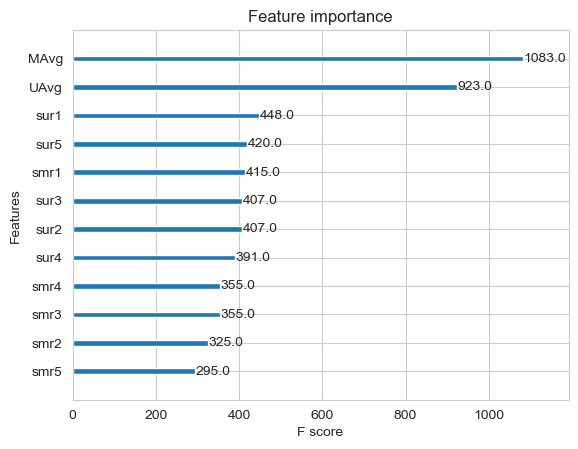

In [71]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(n_jobs=-1, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### Surprise Baseline Model

In [72]:
from surprise import BaselineOnly

__Predicted_rating : ( baseline prediction )__
http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem )__
http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [73]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)

# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.118528 

Evaluating the model with train data..
time taken : 0:00:00.289522
---------------
Train Data
---------------
RMSE : 0.8775786911679883

MAPE : 30.454573244661404

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.068315
---------------
Test Data
---------------
RMSE : 1.0243005039853545

MAPE : 40.20855003829862

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.477869


### Surprise KNNBaseline predictor

In [74]:
from surprise import KNNBaseline

- KNN BASELINE
http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 
    
- PEARSON_BASELINE SIMILARITY
http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
<br>_2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 


- __predicted Rating__ : ___(based on User-User similarity)___

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
    


- __Predicted rating__: ___(based on Item-Item similarity)___
<br>

 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

_Notations follows same as above (user-user based predicted rating)_

#### Surprise KNNBaseline with user user similarities

In [75]:
# we specify, how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 10,
               'min_support': 1
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=20, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:00.290215 

Evaluating the model with train data..
time taken : 0:00:03.330499
---------------
Train Data
---------------
RMSE : 0.3951643796917806

MAPE : 11.691316963163043

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.190344
---------------
Test Data
---------------
RMSE : 1.0169764581401328

MAPE : 39.72756795257239

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:03.811058


#### Surprise KNNBaseline with movie movie similarities

In [76]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:03.315056 

Evaluating the model with train data..
time taken : 0:00:14.086039
---------------
Train Data
---------------
RMSE : 0.3251522121040674

MAPE : 9.584317551359922

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.350849
---------------
Test Data
---------------
RMSE : 1.0156721891005795

MAPE : 39.773592408563566

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:17.751944


### SVD Matrix Factorization User Movie intractions

In [77]:
from surprise import SVD

__Predicted Rating :__

- $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
 
- $\pmb q_i$ - Representation of item(movie) in latent factor space

- $\pmb p_u$ - Representation of user in new latent factor space
        


__Optimization problem with user item interactions and regularization (to avoid overfitting)__
- $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [78]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:00.368124 

Evaluating the model with train data..
time taken : 0:00:00.350048
---------------
Train Data
---------------
RMSE : 0.6425277541917895

MAPE : 21.355403527437648

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.066197
---------------
Test Data
---------------
RMSE : 1.0143397346127099

MAPE : 39.70910979880776

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:00.784369


### SVD Matrix Factorization with implicit feedback from user (user rated movies)

In [79]:
from surprise import SVDpp

__Predicted Rating :__
    - <br>
- $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 
    
- $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.   

__Optimization problem with user item interactions and regularization (to avoid overfitting)__
     
- $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 


In [80]:
# initiallize the model
svdpp = SVDpp(n_factors=120, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results

Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:03:33.815523 

Evaluating the model with train data..
time taken : 0:00:20.753967
---------------
Train Data
---------------
RMSE : 0.4680545608406275

MAPE : 14.806118909320338

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.406120
---------------
Test Data
---------------
RMSE : 1.0142587691439953

MAPE : 39.63322618001881

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:03:54.975610


### XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

__Preparing Train data__

In [81]:
# add the predicted values from both knns to this dataframe
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']


reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,429,595,3.508498,5.0,2.0,5.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,3.982759,3.779851,5.0,4.105069,4.806941,4.846703,4.573875,4.773115
1,429,588,3.508498,4.0,5.0,4.0,2.0,4.0,5.0,5.0,5.0,4.0,5.0,3.982759,3.776398,5.0,4.116153,4.605823,4.929342,4.400657,4.552991


In [82]:
# add the predicted values from both knns to this dataframe
reg_test_df['bslpr'] = models_evaluation_test['bsl_algo']['predictions']
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']


reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,495,72998,3.508498,5.0,5.0,1.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,4.466667,3.712963,5.0,4.004035,4.992033,4.902771,4.578276,4.839619
1,495,2762,3.508498,4.0,3.5,4.5,4.5,4.0,5.0,5.0,4.0,5.0,4.5,4.466667,3.887417,4.5,4.205590,4.460026,4.421323,4.638795,4.453357


Training the model..
Done. Time taken : 0:00:02.449379

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.6822591707733902
MAPE :  20.904088508623566
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.040607545907021
MAPE :  39.29997524836969


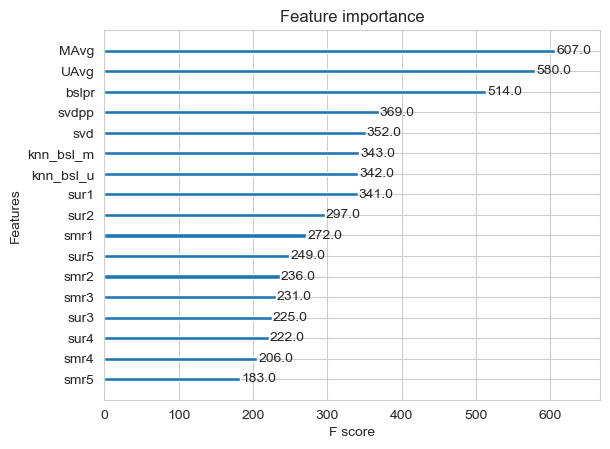

In [83]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=-1, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

Training the model..
Done. Time taken : 0:00:08.393193

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.6414831876300052
MAPE :  19.414450515971875
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0363351872831497
MAPE :  38.86334607694032


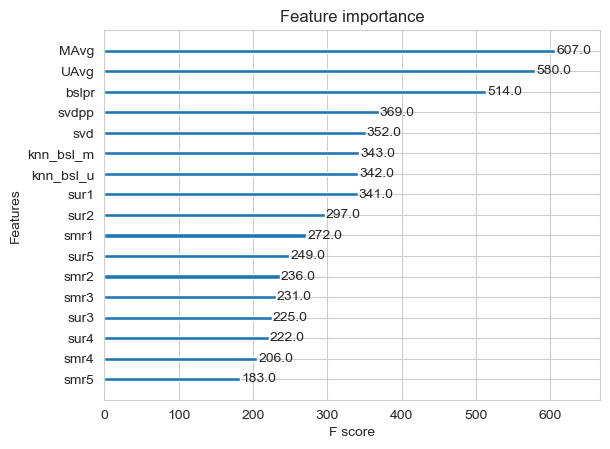

In [84]:
# Hyperparamter tuning & then predict and store the results in models_evaluations dictionaries
params_grid = {
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 300,500,1000],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_final_params = {'subsample': [1.0],
 'n_estimators': [300],
 'max_depth': [7],
 'learning_rate': [0.1],
 'gamma': [0.2],
 'colsample_bytree': [0.9]}

xgb_final_tuned,xgb_final_params = xgb_hyperparameter_tuning(x_train,y_train,xgb_final_params) # <<--------------- Replace with param grid to run Random Search again
train_results, test_results = run_xgboost(xgb_final_tuned, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final_tuned'] = train_results
models_evaluation_test['xgb_final_tuned'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

## XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques

Training the model..
Done. Time taken : 0:00:02.180199

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.9714374921626167
MAPE :  34.37802746525494
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.072952256023652
MAPE :  41.721408705936675


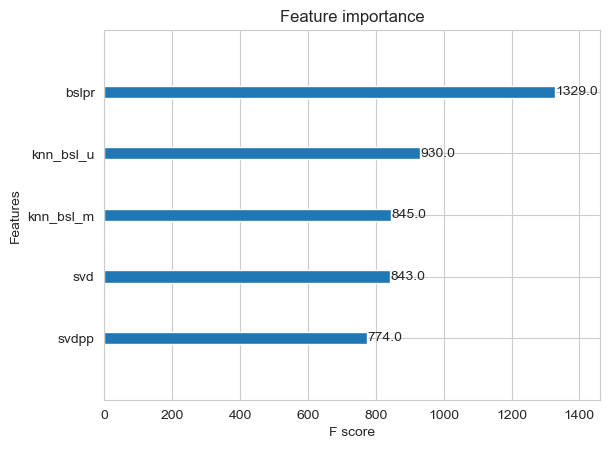

In [85]:
# prepare train data
x_train = reg_train[['bslpr','knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['bslpr','knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=-1, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

Training the model..
Done. Time taken : 0:00:08.836804

Done 

Evaluating the model with TRAIN data...

TRAIN DATA
------------------------------
RMSE :  0.9715499531513121
MAPE :  34.51442650632464
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0714723995980922
MAPE :  41.69228084909909


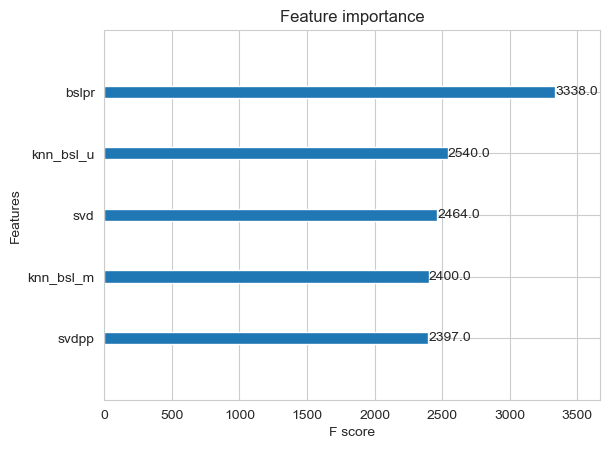

In [86]:
# Hyperparamter tuning & then predict and store the results in models_evaluations dictionaries

xgb_all_models_params = {'subsample': [0.9],
         'n_estimators': [500],
         'max_depth': [5],
         'learning_rate': [0.1],
         'gamma': [0],
         'colsample_bytree': [0.8]}

xgb_all_models_tuned,xgb_all_models_params = xgb_hyperparameter_tuning(x_train,y_train,xgb_all_models_params) # <<--------------- Replace with param grid to run Random Search again
train_results, test_results = run_xgboost(xgb_all_models_tuned, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models_tuned'] = train_results
models_evaluation_test['xgb_all_models_tuned'] = test_results


xgb.plot_importance(xgb_all_models_tuned)
plt.show()

## Comparision between all models

In [87]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('./final_results.csv')
models = pd.read_csv('./final_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svdpp                   1.0142587691439953
svd                     1.0143397346127099
knn_bsl_m               1.0156721891005795
knn_bsl_u               1.0169764581401328
bsl_algo                1.0243005039853545
xgb_final_tuned         1.0363351872831497
xgb_final                1.040607545907021
first_algo              1.0558161428009392
xgb_all_models_tuned    1.0714723995980922
xgb_all_models           1.072952256023652
Name: rmse, dtype: object

<div style="background-color: lightblue; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h1><b>SVDPP Model Interpretations & Validation</b></h1>
</div>

**Let's say we want to check for user `576` based on our model what will be the rating of different movies present in the data and what can we recommend based on users past view**

In [233]:
# movies rated by the user 298
val_user = 576

In [254]:
def recommendation_based_on_past_ratings(val_user):
    try : 
        # Creating an array for all movies present in the data
        unique_movies = ratings['movieId'].unique()

        rating_val_user = dict()
        rating_val_user['movieId']=list()
        rating_val_user['predicted_rating'] = list()

        for i in unique_movies:
            rating_val_user['movieId'].append(i)
            rating_val_user['predicted_rating'].append(svdpp.predict(val_user,i).est)

        # users predicted ratings dataframe for all movies 
        prediction_val_user = pd.DataFrame(rating_val_user)

        watched_movies_data= pd.merge(ratings,movies,how='inner',on='movieId')

        watched_movies_data = watched_movies_data[watched_movies_data['userId']==val_user][['movieId','rating']]

        num_watched_movies_val_user = len(watched_movies_data)

        final_val_user_df = pd.merge(watched_movies_data,prediction_val_user,how='outer',on='movieId')            # Picking the watched movieId and rating from watched_movieS_data
        final_val_user_df = pd.merge(final_val_user_df,movies,how='outer',on='movieId')                           # picking the titles and release year of all movies from the movies data 
        final_val_user_df = final_val_user_df[['movieId', 'title', 'release_year','rating', 'predicted_rating']]  # changing the order of the columns 
        final_val_user_df['error'] = final_val_user_df['rating'] - final_val_user_df['predicted_rating']

        recommendations = final_val_user_df[final_val_user_df['rating'].isna()].sort_values(by='predicted_rating',ascending=False).head(10)[['movieId','title','release_year','predicted_rating']]

        # display(final_val_user_df.head(num_watched_movies_val_user))

        ## Final 10 recommendations based on SVDPP model 

    return recommendations
    

<div style="background-color: orange; text-align: center; padding: 10px; position: relative; border-radius: 10px">
    <h2><b>User Movie Recommendation Widget</b></h2>
</div>

In [269]:
# Widget Creation 
userid_input = widgets.Text(
    value='582',
    description="<h3>Enter user's ID here:</h3>",
    disabled=False,
    style={'description_width': '150px'} 
)

recommeded_movie_list = widgets.Output()

def on_type(data):
    try:
        user = int(data["new"])
        with recommeded_movie_list:
            recommeded_movie_list.clear_output()
            if user > 0:
                display(recommendation_based_on_past_ratings(user))
    except:
        with recommeded_movie_list:
            recommeded_movie_list.clear_output()
            print("Enter a valid User ID")

userid_input.observe(on_type, names='value')


display(userid_input,recommeded_movie_list)

Text(value='582', description="<h3>Enter user's ID here:</h3>", style=DescriptionStyle(description_width='150p…

Output()